In [24]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

fatal: destination path 'deep-image-prior' already exists and is not an empty directory.
mv: cannot stat 'deep-image-prior/*': No such file or directory


# Import libs

In [25]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [26]:
# deJPEG
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

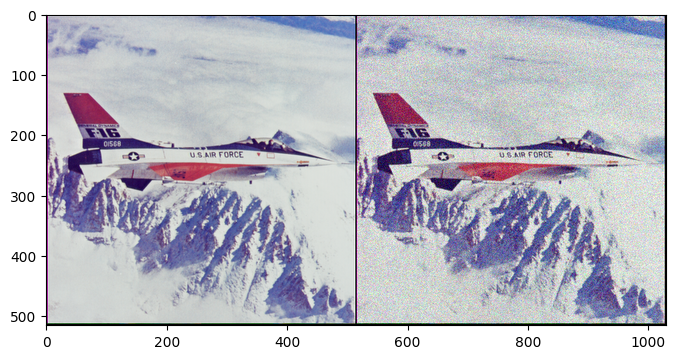

In [34]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)

    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np

    if PLOT:
        plot_image_grid([img_np], 4, 5);

elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)

    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [41]:
def optimize(optimizer_type, parameters, closure, LR, num_iter):
    if optimizer_type == 'LBFGS':
        print('Warming up with Adam before LBFGS...')
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            loss = closure()
            optimizer.step()
        print('Starting optimization with LBFGS')
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR)
        optimizer.step(closure2)

    else:
        opt_class = {
            'adam': torch.optim.Adam,
            'SGD': torch.optim.SGD,
            'RMSprop': torch.optim.RMSprop,
            'AdamW': torch.optim.AdamW,
            'Adadelta': torch.optim.Adadelta,
            'RAdam': torch.optim.RAdam,
            'Adafactor': torch.optim.Adafactor
        }[optimizer_type]
        optimizer = opt_class(parameters, lr=LR)
        print(f'Starting optimization with {optimizer_type.upper()}')
        for j in range(num_iter):
            optimizer.zero_grad()
            loss = closure()
            optimizer.step()

In [43]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

# reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.02

show_every = 1
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5

    net = skip(
                input_depth, 3,
                num_channels_down = [8, 16, 32, 64, 128],
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4],
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    input_depth = 32
    figsize = 4


    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


# Optimize


===== Running ADAM =====
Starting optimization with ADAM
[adam] Iter 00001 | Loss 0.0926 | PSNR_gt 10.76 | PSNR_gt_sm 10.76
[adam] Iter 00002 | Loss 0.0531 | PSNR_gt 13.54 | PSNR_gt_sm 10.81
[adam] Iter 00003 | Loss 0.0827 | PSNR_gt 11.32 | PSNR_gt_sm 10.86
[adam] Iter 00004 | Loss 0.0630 | PSNR_gt 12.68 | PSNR_gt_sm 10.95
[adam] Iter 00005 | Loss 0.0619 | PSNR_gt 12.77 | PSNR_gt_sm 11.03
[adam] Iter 00006 | Loss 0.0436 | PSNR_gt 14.62 | PSNR_gt_sm 11.11
[adam] Iter 00007 | Loss 0.0376 | PSNR_gt 15.44 | PSNR_gt_sm 11.17
[adam] Iter 00008 | Loss 0.0356 | PSNR_gt 15.75 | PSNR_gt_sm 11.23
[adam] Iter 00009 | Loss 0.0352 | PSNR_gt 15.82 | PSNR_gt_sm 11.29
[adam] Iter 00010 | Loss 0.0330 | PSNR_gt 16.21 | PSNR_gt_sm 11.36
[adam] Iter 00011 | Loss 0.0345 | PSNR_gt 15.96 | PSNR_gt_sm 11.43
[adam] Iter 00012 | Loss 0.0325 | PSNR_gt 16.30 | PSNR_gt_sm 11.49
[adam] Iter 00013 | Loss 0.0316 | PSNR_gt 16.47 | PSNR_gt_sm 11.56
[adam] Iter 00014 | Loss 0.0302 | PSNR_gt 16.75 | PSNR_gt_sm 11.63
[ada

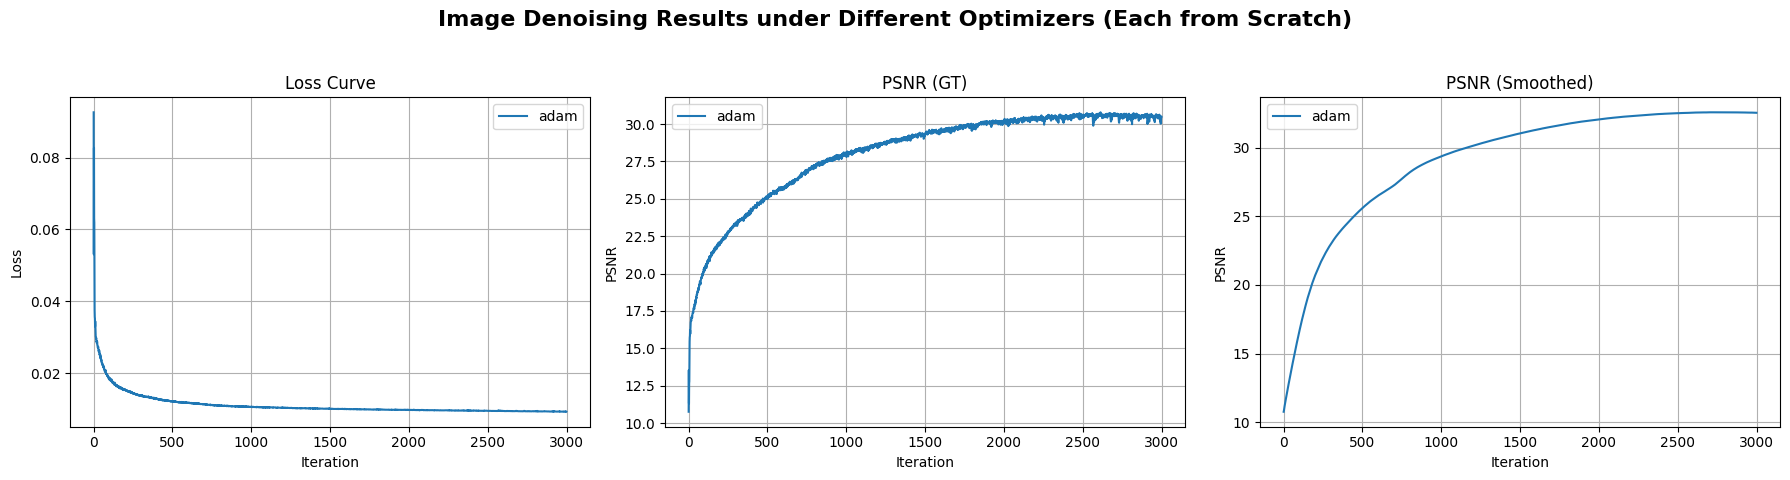

In [44]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import numpy as np

OPTIMIZER_LIST = ['adam']#['SGD', 'adam', 'RMSprop', 'AdamW', 'Adadelta']
results = {}

def run_optimizer(OPTIMIZER):
    print(f"\n===== Running {OPTIMIZER.upper()} =====")

    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

    net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()

    out_avg = None
    last_net = None
    psrn_noisy_last = 0

    loss_values = []
    psnr_values = []
    psnr_sm_values = []

    exp_weight = 0.99
    i = 0

    def closure():
        nonlocal i, out_avg, psrn_noisy_last, last_net, net_input

        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)

        out = net(net_input)

        # Smoothing
        if out_avg is None:
            out_avg = out.detach()
        else:
            out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

        total_loss = mse(out, img_noisy_torch)
        total_loss.backward()

        loss_values.append(total_loss.item())
        psrn_gt = compare_psnr(img_np, out.detach().cpu().numpy()[0])
        psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])
        psnr_values.append(psrn_gt)
        psnr_sm_values.append(psrn_gt_sm)


        if (i + 1) % show_every == 0:
            print(f"[{OPTIMIZER}] Iter {i+1:05d} | Loss {total_loss.item():.4f} | PSNR_gt {psrn_gt:.2f} | PSNR_gt_sm {psrn_gt_sm:.2f}")
        # print(f"[{OPTIMIZER}] Iter {i+1:05d} | Loss {total_loss.item():.4f} | PSNR_gt {psrn_gt:.2f} | PSNR_gt_sm {psrn_gt_sm:.2f}")
        i += 1
        return total_loss

    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER, p, closure, LR, num_iter)

    return {
        'loss': loss_values,
        'psnr': psnr_values,
        'psnr_sm': psnr_sm_values
    }


# ========== main loop ==========
for OPTIMIZER in OPTIMIZER_LIST:
    results[OPTIMIZER] = run_optimizer(OPTIMIZER)


plt.figure(figsize=(18, 5))
# ---- (1) Loss ----
plt.subplot(1, 3, 1)
for opt_name, data in results.items():
    plt.plot(data['loss'], label=opt_name)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
# ---- (2) PSNR (GT) ----
plt.subplot(1, 3, 2)
for opt_name, data in results.items():
    plt.plot(data['psnr'], label=opt_name)
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.title('PSNR (GT)')
plt.legend()
plt.grid(True)
# ---- (3) PSNR (Smoothed) ----
plt.subplot(1, 3, 3)
for opt_name, data in results.items():
    plt.plot(data['psnr_sm'], label=opt_name)
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.title('PSNR (Smoothed)')
plt.legend()
plt.grid(True)

plt.suptitle('Image Denoising Results under Different Optimizers (Each from Scratch)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# SGD

Number of params: 2217831
Starting optimization with SGD
Iteration 00000    Loss 0.087323   PSNR_noisy: 10.588693   PSRN_gt: 11.034867 PSNR_gt_sm: 11.034867
Iteration 00001    Loss 0.053418   PSNR_noisy: 12.723115   PSRN_gt: 13.495290 PSNR_gt_sm: 11.067361
Iteration 00002    Loss 0.042174   PSNR_noisy: 13.749580   PSRN_gt: 14.785850 PSNR_gt_sm: 11.128649
Iteration 00003    Loss 0.045908   PSNR_noisy: 13.381105   PSRN_gt: 14.341029 PSNR_gt_sm: 11.209821
Iteration 00004    Loss 0.047501   PSNR_noisy: 13.233018   PSRN_gt: 14.162536 PSNR_gt_sm: 11.299828
Iteration 00005    Loss 0.041188   PSNR_noisy: 13.852343   PSRN_gt: 14.945807 PSNR_gt_sm: 11.390909
Iteration 00006    Loss 0.039055   PSNR_noisy: 14.083212   PSRN_gt: 15.241745 PSNR_gt_sm: 11.478389
Iteration 00007    Loss 0.033743   PSNR_noisy: 14.718221   PSRN_gt: 16.095387 PSNR_gt_sm: 11.560270
Iteration 00008    Loss 0.033848   PSNR_noisy: 14.704631   PSRN_gt: 16.063470 PSNR_gt_sm: 11.632150
Iteration 00009    Loss 0.031673   PSNR_noi

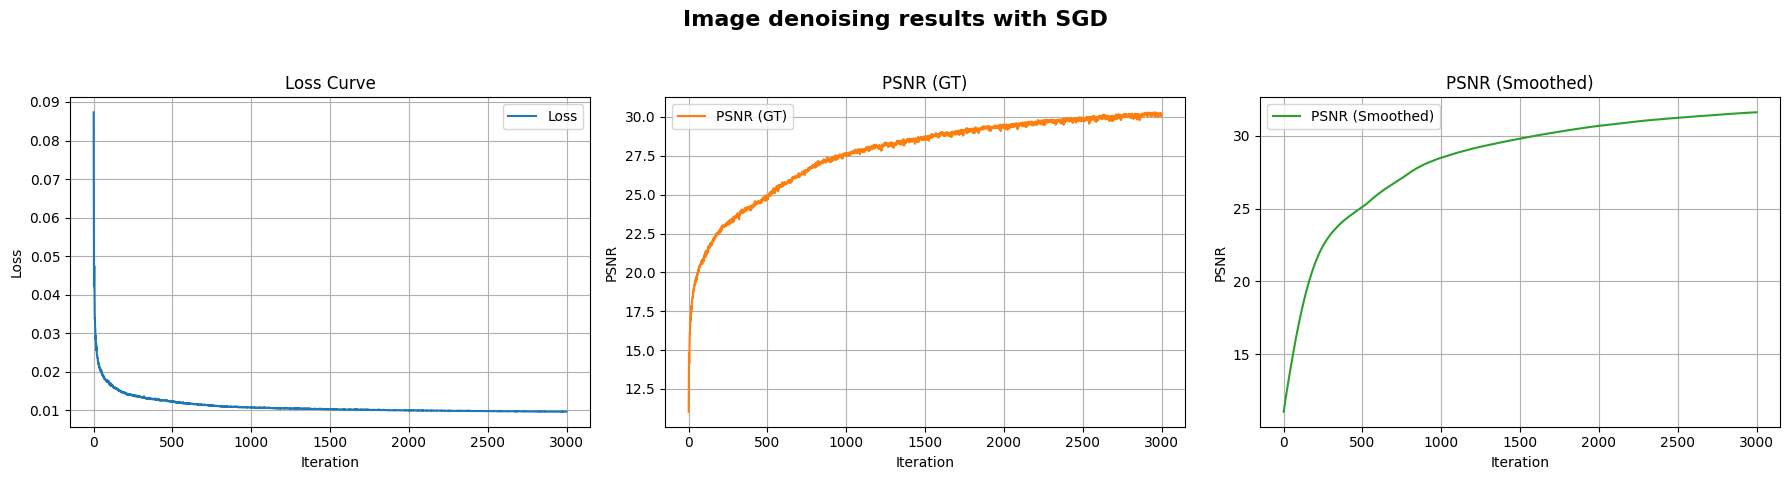

In [33]:
## For SGD, add the momentum and with small LR
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
psnr_values = []
psnr_sm_values = []
loss_values = []
# reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 1

OPTIMIZER='SGD' # 'LBFGS'
show_every = 1#500
exp_weight=0.99

def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.

    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with Adam')
        optimizer = torch.optim.Adam(parameters, lr=LR)

        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()

    elif optimizer_type == 'SGD':
        print('Starting optimization with SGD')
        optimizer = torch.optim.SGD(parameters, lr=LR, momentum=0.9) ######## here, add the momentum and with small LR
        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5

    net = skip(
                input_depth, 3,
                num_channels_down = [8, 16, 32, 64, 128],
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4],
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    input_depth = 32
    figsize = 4

    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

# optimize
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
    loss_values.append(total_loss.item())

    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0])
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0])
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])
    psnr_values.append(psrn_gt)
    psnr_sm_values.append(psrn_gt_sm)

    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm))
    # if  PLOT and i % show_every == 0:
    #     out_np = torch_to_np(out)
    #     plot_image_grid([np.clip(out_np, 0, 1),
    #                      np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize)



    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---- (1) Loss ----
axes[0].plot(range(len(loss_values)), loss_values, label='Loss', color='tab:blue')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curve')
axes[0].legend()
axes[0].grid(True)

# ---- (2) PSNR (GT) ----
axes[1].plot(range(len(psnr_values)), psnr_values, label='PSNR (GT)', color='tab:orange')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('PSNR')
axes[1].set_title('PSNR (GT)')
axes[1].legend()
axes[1].grid(True)

# ---- (3) PSNR (Smoothed) ----
axes[2].plot(range(len(psnr_sm_values)), psnr_sm_values, label='PSNR (Smoothed)', color='tab:green')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('PSNR')
axes[2].set_title('PSNR (Smoothed)')
axes[2].legend()
axes[2].grid(True)

fig.suptitle('Image denoising results with SGD', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

